<a href="https://colab.research.google.com/github/WellFan/bayesian_with_baseball/blob/main/baseball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are studying Lahman dataset, which contains baseball game datas from MLB.  
We will be  
1. Using bayesion technique to compute the hitting rate  
2. Adding hierarchical model
3. Using Stan package

to help us understand what bayesian does.


---


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
batting = pd.read_csv("https://raw.githubusercontent.com/WellFan/bayesian_with_baseball/main/baseballdatabank-2022.2/core/Batting.csv")
pitching = pd.read_csv("https://raw.githubusercontent.com/WellFan/bayesian_with_baseball/main/baseballdatabank-2022.2/core/Pitching.csv")

In [ ]:
batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


---
Generating 

\[H]: hit

[AB]: at bat

[AVG]: batting average

---

In [ ]:
career = batting[batting.AB > 0]
career = pd.merge(career, pitching, how='outer', on='playerID', indicator=True)
career = (career[~(career._merge == 'both')]
          .drop('_merge', axis=1).groupby(by='playerID')
          .sum()[['H_x', 'AB']]
          .assign(average=lambda df:df.H_x / df.AB)
          .rename(columns={'H_x':'H', 'average':'AVG'})
)
career.head()

,H,AB,AVG
playerID,,,
aaronha01,3771.0,12364.0,0.304998
aaronto01,216.0,944.0,0.228814
abadan01,2.0,21.0,0.095238
abadijo01,11.0,49.0,0.224490
abbated01,772.0,3044.0,0.253614


In [ ]:
people = pd.read_csv("https://github.com/WellFan/bayesian_with_baseball/blob/main/baseballdatabank-2022.2/core/People.csv?raw=true")
master = people[['playerID', 'nameFirst', 'nameLast']]
master = master.assign(name = lambda df:df.nameFirst + ' ' + df.nameLast)
master = master[['name', 'playerID']]
career_name = pd.merge(master, career, how='inner', on='playerID')
career_name = career_name.drop(columns = 'playerID')
career_name.head()

,name,H,AB,AVG
0,Hank Aaron,3771.0,12364.0,0.304998
1,Tommie Aaron,216.0,944.0,0.228814
2,Andy Abad,2.0,21.0,0.095238
3,John Abadie,11.0,49.0,0.224490
4,Ed Abbaticchio,772.0,3044.0,0.253614


In [ ]:
career_name.nlargest(5, 'AVG')

,name,H,AB,AVG
461,Jeff Banister,1.0,1.0,1.0
590,Doc Bass,1.0,1.0,1.0
876,Steve Biras,2.0,2.0,1.0
1451,C. B. Burns,1.0,1.0,1.0
3738,Jackie Gallagher,1.0,1.0,1.0


In [ ]:
career_name.nsmallest(5, 'AVG')

,name,H,AB,AVG
10,Frank Abercrombie,0.0,4.0,0.0
136,Horace Allen,0.0,7.0,0.0
144,Pete Allen,0.0,4.0,0.0
177,Walter Alston,0.0,1.0,0.0
210,Trey Amburgey,0.0,4.0,0.0


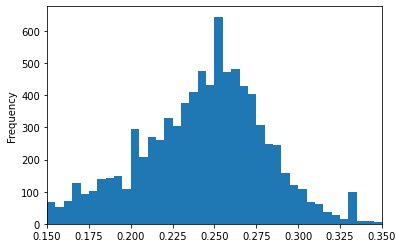

In [ ]:
career_name['AVG'].plot.hist(xlim=[0.15, 0.35], bins=200, xlabel='average', ylabel='count')

---
Fitting the overall AVG with beta distribution. Getting the approximated $α, β$ 

---

In [ ]:
from scipy.stats import beta
career_filter = career_name[career_name.AB > 500]
a0, b0, loc1, scale1 = beta.fit(career_filter['AVG'], floc=0, fscale=1)
print("alpha =", a0, "\n", "beta =", b0)

alpha = 79.6411398927643 
 beta = 228.55257615856598


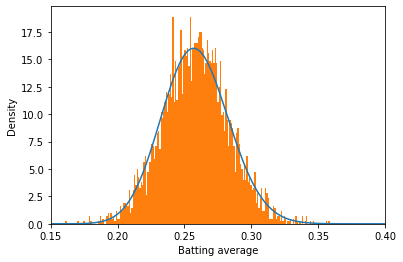

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a0, b0)
plt.plot(x, y)
plt.hist(career_filter['AVG'], bins=200, density=True)
plt.xlabel('Batting average')
plt.ylabel('Density')
plt.xlim(0.15, 0.4)
plt.show()

---
[likelihood_analytical]: MLE of betabinomial model


\[likelihood]: Consider the following hierarchical moddel 

$μ_i = β_0 + β_1*lnAB_i+ϵ=\frac{\alpha_i}{\alpha_i+\beta_i}\\
\sigma_0 = \frac{1}{\alpha_i+\beta_i}\\
\alpha_i = \frac{\mu_i}{\sigma_0}\\
\beta_i = \frac{(1-\mu_i)}{\sigma_0}\\
p_i∼Beta(α_i, \beta_i)$

and compute the MLE

---

In [ ]:
from scipy.optimize import minimize
from scipy import special
from scipy import stats
x_i = np.array(career_filter['AVG'])
AB = np.array(career_filter['AB'])
logAB = np.array(np.log(career_filter['AB']))
H = np.array(career_filter['H'])
def likelihood(para):
  mu_i = para[0] + para[1] * logAB
  A_i = mu_i/para[2]-1
  B_i = (1-mu_i)/para[2]-1
  return -1 * sum(A_i * np.log(x_i) + B_i * np.log(1 - x_i) - special.gammaln(A_i + 1) - special.gammaln(B_i + 1) + special.gammaln(1/para[2]))
def likelihood_analytical(para):
  a = para[0]
  b = para[1]
  return -1 * sum((stats.betabinom.logpmf(H, AB, a, b)))

In [ ]:
print(H)
print(stats.betabinom.pmf(H, AB, 79, 228))

[3771.  216.  772. ...  518.  199.  364.]
[0.00021914 0.00940388 0.00499551 ... 0.00063119 0.01683816 0.00670845]


Compute the parameters $\beta_0, \beta_1, \sigma_0$ of the hierarchical model

In [ ]:
para0 = np.array([0.143, 0.015, 0.002])
res = minimize(likelihood, para0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
res.x

Optimization terminated successfully.
         Current function value: -10452.862593
         Iterations: 89
         Function evaluations: 174


array([0.13297192, 0.01642835, 0.00234517])

---
Compute the parameters $\alpha, \beta$ of the betabinomial model

---

In [ ]:
para0 = np.array([50, 290])
res = minimize(likelihood_analytical, para0, method='nelder-mead', options={'xatol': 1e-16, 'disp': True})
a1, b1 = res.x
res.x

Optimization terminated successfully.
         Current function value: 22947.704308
         Iterations: 118
         Function evaluations: 272


array([101.82219115, 289.62396127])

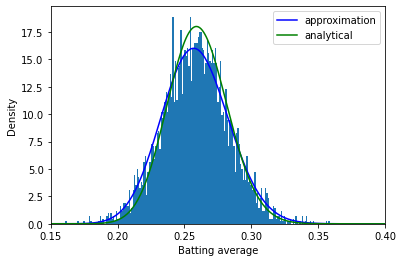

In [ ]:
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a0, b0)
y_2 = beta.pdf(x, a1, b1)
plt.plot(x, y, color='blue', label='approximation')
plt.plot(x, y_2, color='green', label='analytical')
plt.hist(career_filter['AVG'], bins=200, density=True)
plt.xlabel('Batting average')
plt.ylabel('Density')
plt.xlim(0.15, 0.4)
plt.legend()
plt.show()

---
Consider the following model:

$\mu_i = β_0 + β_1*lnAB_i+\beta_2*bats+ϵ=\frac{\alpha_i}{\alpha_i+\beta_i}\\
\sigma_0=\frac{1}{\alpha_i+\beta_i}\\
α_i = \frac{\mu_i}{\sigma_0}\\
\beta_i=\frac{(1-\mu_i)}{\sigma_0}\\
p_i∼Beta(α_i, \beta_i)$

and compute the MLE

---

In [ ]:
career_filter = career_filter.assign(
    AVG_approxi=lambda df: (df.H + a0) / (df.AB + a0 + b0),
    AVG_analytical=lambda df: (df.H + a1) / (df.AB + a1 + b1))
career_filter.head()

,name,H,AB,AVG,AVG_approxi,AVG_analytical
0,Hank Aaron,3771.0,12364.0,0.304998,0.303865,0.303621
1,Tommie Aaron,216.0,944.0,0.228814,0.236099,0.237990
4,Ed Abbaticchio,772.0,3044.0,0.253614,0.254055,0.254355
5,Fred Abbott,107.0,513.0,0.208577,0.227280,0.230884
7,Jeff Abbott,157.0,596.0,0.263423,0.261715,0.262113


In [ ]:
print(career_filter['AVG'].std(), career_filter['AVG_analytical'].std(), career_filter['AVG_approxi'].std())

0.02485229476400437 0.02005403473980877 0.02088416052274367


In [ ]:
people = pd.read_csv("https://github.com/WellFan/bayesian_with_baseball/blob/main/baseballdatabank-2022.2/core/People.csv?raw=true")
master2 = (people[['playerID', 'nameFirst', 'nameLast', 'bats']]
           .assign(name=lambda df: df.nameFirst+' '+df.nameLast)
           .drop(columns=['nameFirst', 'nameLast']))
career_name2 = pd.merge(master2, career, how='inner', on='playerID')
career_name2 = (career_name2.drop(columns = 'playerID')
                .loc[~career_name2.bats.isnull()]
                .assign(bats = (career_name2.bats=='R').astype('int'))
                .loc[career_name2['AB']>500])
career_name2.head()

,bats,name,H,AB,AVG
0,1,Hank Aaron,3771.0,12364.0,0.304998
1,1,Tommie Aaron,216.0,944.0,0.228814
4,1,Ed Abbaticchio,772.0,3044.0,0.253614
5,1,Fred Abbott,107.0,513.0,0.208577
7,1,Jeff Abbott,157.0,596.0,0.263423


In [ ]:
x_i = np.array(career_name2['AVG'])
logAB = np.array(np.log(career_name2['AB']))
bats = np.array(career_name2['bats'])
def likelihood2(para):
  mu_i = para[0] + para[1] * logAB + para[2] * bats
  A_i = mu_i/para[3]-1
  B_i = (1-mu_i)/para[3]-1
  return -1 * sum(A_i * np.log(x_i) + B_i * np.log(1 - x_i) - special.gammaln(A_i + 1) - special.gammaln(B_i + 1) + special.gammaln(1/para[3]))

In [ ]:
para0 = np.array([0.14, 0.015, -0.01, 0.002])
res = minimize(likelihood2, para0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
res.x

Optimization terminated successfully.
         Current function value: -10404.444435
         Iterations: 160
         Function evaluations: 294


array([ 0.1386039 ,  0.01620308, -0.00661675,  0.00228272])

---
Draw the posterior distribution of 

[r, l]: different handedness


[number]: different at bats

---

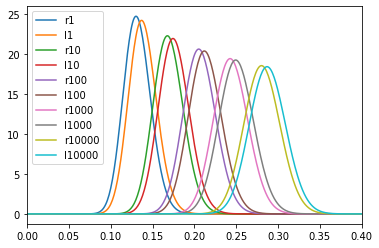

In [ ]:
x = np.linspace(0, 1, 1000)
lr = [1,0] * 5
ab = [1, 1, 10, 10, 100, 100, 1000, 1000, 10000, 10000]
lr = np.array(lr)
ab = np.array(ab)
lnab = np.log(ab)
y = np.zeros((1000, 10))
y = pd.DataFrame(y)
for i in range(10):
  mu_i = res.x[0] + res.x[1] * lnab[i] + res.x[2] * lr[i]
  alpha_i = mu_i/res.x[3]
  beta_i = (1-mu_i)/res.x[3]
  y[i] = beta.pdf(x, alpha_i, beta_i)
for i in range(10):
  plt.plot(x, y[i], label=str("r" if lr[i] == 1 else "l") + str(10**(i // 2)))
plt.legend()
plt.xlim(0, 0.4)
plt.show()

---



Compute the credible interval of different kinds of batter

---

In [ ]:
var = [[3, 10], [30, 100], [300, 1000]]
def leftinterval(list):
  alpha_prior = (res.x[0] + res.x[1] * np.log(list[1]) + res.x[2] * 0) / res.x[3]
  beta_prior = (1 - (res.x[0] + res.x[1] * np.log(list[1]) + res.x[2] * 0)) / res.x[3]
  alpha_post = alpha_prior + list[0]
  beta_post = beta_prior + list[1] - list[0]
  return [beta.ppf(0.025, alpha_post, beta_post), beta.ppf(0.975, alpha_post, beta_post)]
def rightinterval(list):
  alpha_prior = (res.x[0] + res.x[1] * np.log(list[1]) + res.x[2] * 1) / res.x[3]
  beta_prior = (1 - (res.x[0] + res.x[1] * np.log(list[1]) + res.x[2] * 1)) / res.x[3]
  alpha_post = alpha_prior + list[0]
  beta_post = beta_prior + list[1] - list[0]
  return [beta.ppf(0.025, alpha_post, beta_post), beta.ppf(0.975, alpha_post, beta_post)]
print("left when 3/10", leftinterval(var[0]), "\nright when 3/10", rightinterval(var[0]))
print("left when 30/100", leftinterval(var[1]), "\nright when 30/100", rightinterval(var[1]))
print("left when 300/1000", leftinterval(var[2]), "\nright when 300/1000", rightinterval(var[2]))

left when 3/10 [0.14464514414479654, 0.21543521779249564] 
right when 3/10 [0.13871477769031015, 0.20848201419969337]
left when 30/100 [0.1948359550427392, 0.2657682508847931] 
right when 30/100 [0.1897651276126152, 0.2601028986794264]
left when 300/1000 [0.2618972675639635, 0.3085301700541036] 
right when 300/1000 [0.25993421721377297, 0.3064672691630672]


---

Stan package is designed for bayesian research. 

We construct our model and store it in a string or a file, then Stan will use C to compile our code

---

In [ ]:
import stan
import arviz as az
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
text2='''
data{
  int<lower=0> N;
  int<lower=0> AB[N];
  int<lower=0> H[N];
}
parameters{
  real<lower=80, upper=120> alpha;
  real<lower=210, upper=290> beta;
}
model{
  H~beta_binomial(AB, alpha, beta);
}
'''
stan_data = {'N':4245, 'AB':list(career_name2['AB'].astype(int)), 'H': list(career_name2['H'].astype(int))}
posterior = stan.build(text2, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=1000)
df = fit.to_frame()

Building...



Building: 46.0s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1000/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 0.001518 seconds
  1000 transitions using 10 leapfrog steps per transition would take 15.18 seconds.
  Adjust your expectations accordingly!


In [ ]:
print("beta =", df.beta.mean(), 'alpha =', df.alpha.mean())
az.summary(fit)

beta = 285.6619594218583 alpha = 100.503282164517


Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,100.503,1.072,98.398,102.025,0.086,0.061,156.0,147.0,NaN
beta,285.662,3.003,280.153,289.932,0.240,0.170,154.0,222.0,NaN


---

The reason why alpha and beta are highly correlated is because the prior hitting average equals to $\frac{\alpha}{\alpha + \beta}$. In order to maintain the same prior, the ratio of alpha and beta is constant. 

---

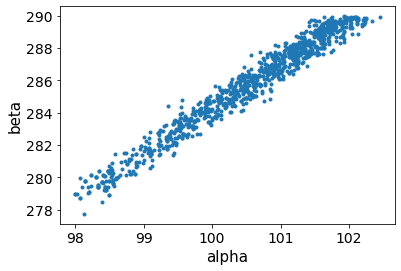

In [ ]:
az.plot_pair(fit)

In [ ]:
text3 = '''
data{
  int<lower=0> N;
  int<lower=0> AB[N];
  int<lower=0> H[N];
}
parameters{
  real<lower=80, upper=120> alpha;
  real<lower=210, upper=290> beta;
  vector<lower=0.001, upper=1>[N] p;
}
model{
  p~beta(alpha, beta);
  H~binomial(AB, p);
}
'''
stan_data = {'N':4245, 'AB':list(career_name2['AB'].astype(int)), 'H': list(career_name2['H'].astype(int))}
posterior = stan.build(text3, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=1000)
df_new = fit.to_frame()

Building...



Building: 56.2s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 0.00169 seconds
  1000 transitions using 10 leapfrog steps per transition would take 16.9 seconds.
  Adjust your expectations accordingly!


In [ ]:
df_new.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,p.1,...,p.4236,p.4237,p.4238,p.4239,p.4240,p.4241,p.4242,p.4243,p.4244,p.4245
draws,,,,,,,,,,,,,,,,,,,,,
0,-6.943818e+06,0.488800,0.07702,6.0,63.0,0.0,6.945932e+06,100.178133,284.186885,0.306509,...,0.234930,0.287563,0.224720,0.272946,0.254519,0.278731,0.243465,0.214325,0.239628,0.268704
1,-6.943822e+06,0.859263,0.07702,6.0,63.0,0.0,6.945950e+06,100.807687,287.342859,0.301644,...,0.244048,0.298980,0.212548,0.279230,0.281300,0.292929,0.283035,0.205800,0.270505,0.292155
2,-6.943766e+06,0.993076,0.07702,6.0,63.0,0.0,6.945915e+06,100.430209,286.180778,0.302468,...,0.241189,0.301292,0.222518,0.271830,0.300207,0.295299,0.285848,0.205746,0.263625,0.295559
3,-6.943808e+06,0.901376,0.07702,6.0,63.0,0.0,6.945997e+06,101.283990,287.318777,0.302821,...,0.236392,0.293767,0.221114,0.284430,0.245229,0.273219,0.249309,0.216897,0.244402,0.256326
4,-6.943772e+06,0.538794,0.07702,6.0,63.0,0.0,6.945935e+06,102.146022,289.121203,0.304108,...,0.227053,0.289640,0.233274,0.286694,0.246989,0.279899,0.249472,0.223029,0.255688,0.260969


---

We want to know whether directly estimate of p is equivalent 
to estimate $\alpha, \beta$. 

---

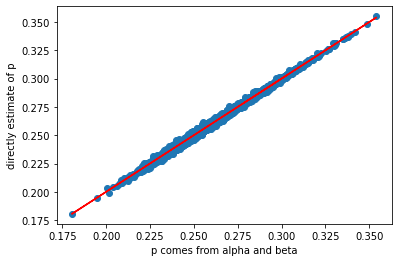

In [ ]:
avg_stan_new = np.array(pd.melt(pd.DataFrame(df_new.iloc[:,9:].mean()), id_vars=None)['value'])
avg_stan = np.array((career_name2['H']+df.alpha.mean())/(career_name2['AB']+df.alpha.mean()+df.beta.mean()))
plt.scatter(avg_stan, avg_stan_new)
plt.xlabel('p comes from alpha and beta')
plt.ylabel('directly estimate of p')
plt.plot(avg_stan, avg_stan, color='red')
plt.show()

In [ ]:
max(abs(avg_stan-avg_stan_new))

0.006370290833837666

---

Consider the following heirarchical model:

$p_i\sim Beta(\alpha_i, \beta_i)\\
H_i\sim Bin(AB_i, p_i)$

Under our assumptions 
1. Good players have more opportunity 
2. Left hitters are different from right hitters

Which means our model is

$\mu_i = \beta_0+\beta_1*logAB_i+\beta_2*bat_i\\
\alpha_i = \frac{\mu_i}{\sigma}\\
\beta_i = \frac{1-\mu_i}{\sigma}$


---


In [ ]:
text='''
data{
  int<lower=0> N;
  int<lower=0> AB[N];
  real logAB[N];
  int<lower=0> H[N];
  int<lower=0, upper=1> bat[N];
}
parameters{
  real<lower=0.13, upper=0.14> beta0;
  real<lower=0.016, upper=0.017> beta1;
  real<lower=-0.007, upper=-0.006> beta2;
  real<lower=0.002, upper=0.003> sigma;
}
transformed parameters{
  vector[N] mu_i;
  vector[N] alpha_i;
  vector[N] beta_i;
  mu_i = beta0 + to_vector(logAB)*beta1  + to_vector(bat)*beta2;
  alpha_i = mu_i/sigma;
  beta_i = (1-mu_i)/sigma;
}
model{
  beta0~normal(0,1);
  beta1~normal(0,1);
  beta2~normal(0,1);
  sigma~normal(0,1);
  H~beta_binomial(AB, alpha_i, beta_i);
}
'''
# 0.1386039 ,  0.01620308, -0.00661675,  0.00228272]

In [ ]:
stan_data = {'N':4245, 'AB':list(career_name2['AB'].astype(int)), 'logAB': list(logAB), 'H': list(career_name2['H'].astype(int)), 'bat': list(bats.astype(int))}
posterior = stan.build(text, data=stan_data)
fit = posterior.sample(num_chains=1, num_samples=1000)
df_hier = fit.to_frame()

Building...



Building: 38.2s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1000/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 0.003379 seconds
  1000 transitions using 10 leapfrog steps per transition would take 33.79 seconds.
  Adjust your expectations accordingly!


In [ ]:
az.summary(fit)

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.136,0.002,0.133,0.140,0.000,0.000,346.0,390.0,NaN
beta1,0.017,0.000,0.016,0.017,0.000,0.000,317.0,303.0,NaN
beta2,-0.007,0.000,-0.007,-0.006,0.000,0.000,396.0,273.0,NaN
sigma,0.002,0.000,0.002,0.002,0.000,0.000,505.0,455.0,NaN
mu_i[0],0.285,0.001,0.284,0.286,0.000,0.000,462.0,548.0,NaN
...,...,...,...,...,...,...,...,...,...
beta_i[4240],363.104,1.521,360.142,364.835,0.061,0.043,552.0,635.0,NaN
beta_i[4241],376.528,1.597,373.562,378.366,0.065,0.046,557.0,606.0,NaN
beta_i[4242],368.841,1.550,365.940,370.654,0.062,0.044,546.0,606.0,NaN
beta_i[4243],378.446,1.609,375.451,380.308,0.065,0.046,559.0,606.0,NaN


In [ ]:
beta0_stan = df_hier.beta0.mean()
beta1_stan = df_hier.beta1.mean()
beta2_stan = df_hier.beta2.mean()
sigma_stan = df_hier.sigma.mean()
career_name2 = career_name2.assign(average_stan=lambda x: ((beta0_stan+beta1_stan*logAB+beta2_stan*bats)+sigma_stan*x['H'])/(1+sigma_stan*x['AB']))
print("beta_0 =", beta0_stan)
print("beta_1 =", beta1_stan)
print("beta_2 =", beta2_stan)
print("sigma =", sigma_stan)

beta_0 = 0.13621741177759453
beta_1 = 0.016501054996828367
beta_2 = -0.006501515684776869
sigma = 0.002008473412429673


---

We found out that those data points with high at bats are close to the diagonal line. And those with low at bats are away from the diagonal line. Intuitively, the information which the players give us are more credible when we observe more data about him. 

In contrary, those with poor observations bring us little information about them, so we need to bias our observation with our prior belief more.

---


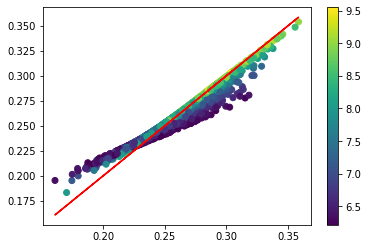

In [ ]:
plt.scatter(career_name2['AVG'], career_name2['average_stan'], c=logAB, cmap='viridis')
plt.plot(career_name2['AVG'], career_name2['AVG'], color='red')
plt.colorbar()